<a href="https://colab.research.google.com/github/shravankumargulvadi/Assignment-7/blob/master/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time


import numpy as np
import imgaug.augmenters as iaa
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Convolution2D, MaxPooling2D 
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.layers import *
from tensorflow.python import space_to_depth
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import Callback

% matplotlib inline
np.random.seed(2017) 

In [0]:
# load train and test data
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

# number of train samples , img_depth, img_height, img_width
num_train, img_channels, img_rows, img_cols =  train_features.shape

# number of test samples
num_test, _, _, _ =  test_features.shape

# number of classes
num_classes = len(np.unique(train_labels))

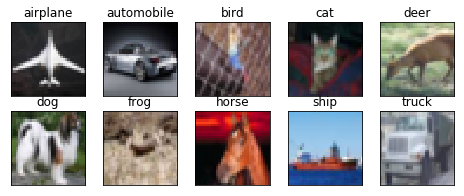

In [3]:
# define individual class names
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# plt each class image
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)
  
def scheduler(epoch, lr):
    return round(0.003 * 1/(1 + 0.319 * epoch), 10)

In [0]:
# pixel normalization
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Model definition:

In [6]:
# Input.........................................................................
input_layer = Input(shape=[32, 32, 3]) 

# layer2........................................................................
layer2 = SeparableConv2D(filters=16, 
                         kernel_size=(5,5), 
                         padding='same',
                         depthwise_regularizer=l2(0.0001), 
                         pointwise_regularizer=l2(0.0001),
                         depthwise_initializer='he_normal', 
                         pointwise_initializer='he_normal' )(input_layer)
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)

# layer3........................................................................
layer3 = Conv2D(filters=32,
                kernel_size=(5,5),
                padding='same',
                kernel_regularizer=l2(0.0001),
                kernel_initializer='he_normal')(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = Activation('relu')(layer3)

# layer4........................................................................
layer4 = Conv2D(filters=32, 
                kernel_size=(5,5),
                kernel_regularizer=l2(0.0001),
                padding='same',
                kernel_initializer='he_normal')(layer3)
layer4 = BatchNormalization()(layer4)
layer4 = Activation('relu')(layer4)

# layer5........................................................................
layer5_stacked_input = Concatenate(axis=-1)([layer2, layer4])

## compress the stacked layers using 1x1
layer5_stacked_input = Conv2D(filters=32,
                              kernel_size=(1,1),
                              padding='same',
                              kernel_regularizer=l2(0.0001),
                              kernel_initializer='he_normal')(layer5_stacked_input)
layer5_stacked_input = BatchNormalization()(layer5_stacked_input)
layer5_stacked_input = Activation('relu')(layer5_stacked_input)

layer5 = Conv2D(filters=32, 
                kernel_size=(5,5),
                padding='same',
                kernel_regularizer=l2(0.0001),
                kernel_initializer='he_normal')(layer5_stacked_input)
layer5 = BatchNormalization()(layer5)
layer5 = Activation('relu')(layer5)

# maxpool1......................................................................
maxpooling1_stacked_input = Concatenate(axis=-1)([layer2, layer5]) 
maxpooling1 = MaxPooling2D(pool_size=(2,2))(maxpooling1_stacked_input)
maxpooling1 = Conv2D(filters=32,
                     kernel_size=(1,1),
                     kernel_regularizer=l2(0.0001),
                     kernel_initializer='he_normal',
                     padding='same')(maxpooling1)
maxpooling1 = BatchNormalization()(maxpooling1)
maxpooling1 = Activation('relu')(maxpooling1)

# adjusting channel dimension to concatenate....................................
layer2 = space_to_depth(layer2, 2)
layer3 = space_to_depth(layer3, 2 )
layer4 = space_to_depth(layer4, 2 )
layer5 = space_to_depth(layer5, 2 )

# layer6........................................................................
layer6 = SeparableConv2D(filters=32,
                         kernel_size=(3,3), 
                         padding='same',
                         depthwise_regularizer=l2(0.0001), 
                         pointwise_regularizer=l2(0.0001),
                         depthwise_initializer='he_normal', 
                         pointwise_initializer='he_normal' )(maxpooling1)
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)

# layer7........................................................................
layer7_stacked_input = Concatenate(axis=-1)([layer2, layer5, layer6])

## compress the stacked layers using 1x1
layer7_stacked_input = Conv2D(filters=32, 
                              kernel_size=(1,1), 
                              kernel_regularizer=l2(0.0001),
                              kernel_initializer='he_normal',
                              padding='same')(layer7_stacked_input)
layer7_stacked_input = BatchNormalization()(layer7_stacked_input)
layer7_stacked_input = Activation('relu')(layer7_stacked_input)

layer7 = Conv2D(filters=32,
                kernel_size=(5,5), 
                padding='same', 
                kernel_regularizer=l2(0.0001),
                kernel_initializer='he_normal')(layer7_stacked_input)
layer7 = BatchNormalization()(layer7)
layer7 = Activation('relu')(layer7)

# layer8........................................................................
layer8_stacked_input = Concatenate(axis=-1)([layer4, layer5, layer6, layer7])

## compress the stacked layers using 1x1
layer8_stacked_input = Conv2D(filters=32, 
                              kernel_size=(1,1), 
                              kernel_regularizer=l2(0.0001),
                              kernel_initializer='he_normal',
                              padding='same')(layer8_stacked_input)
layer8_stacked_input = BatchNormalization()(layer8_stacked_input)
layer8_stacked_input = Activation('relu')(layer8_stacked_input)

layer8 = SeparableConv2D(filters=32,
                         kernel_size=(3, 3), 
                         padding='same', 
                         depthwise_regularizer=l2(0.0001), 
                         pointwise_regularizer=l2(0.0001),
                         depthwise_initializer='he_normal', 
                         pointwise_initializer='he_normal' )(layer8_stacked_input)
layer8 = BatchNormalization()(layer8)
layer8 = Activation('relu')(layer8)

# layer9........................................................................
layer9_stacked_input = Concatenate(axis=-1)([layer2, layer4, layer5, layer6, layer7, layer8])

## compress the stacked layers using 1x1
layer9_stacked_input = Conv2D(filters=32,
                              kernel_size=(1,1), 
                              kernel_regularizer=l2(0.0001),
                              kernel_initializer='he_normal',
                              padding='same')(layer9_stacked_input)
layer9_stacked_input = BatchNormalization()(layer9_stacked_input)
layer9_stacked_input = Activation('relu')(layer9_stacked_input)

layer9 = SeparableConv2D(filters=32,
                         kernel_size=(5, 5), 
                         padding='same', 
                         depthwise_regularizer=l2(0.0001), 
                         pointwise_regularizer=l2(0.0001),
                         depthwise_initializer='he_normal', 
                         pointwise_initializer='he_normal' )(layer9_stacked_input)
layer9 = BatchNormalization()(layer9)
layer9 = Activation('relu')(layer9)

# maxpool2......................................................................
maxpooling2_stacked_input = Concatenate(axis=-1)([layer2, layer5, layer6, layer8, layer9]) 
maxpooling2 = MaxPooling2D(pool_size=(2,2), padding='same')(maxpooling2_stacked_input)
maxpooling2 = Conv2D(filters=32, 
                     kernel_size=(1,1),
                     kernel_regularizer=l2(0.0001),
                     kernel_initializer='he_normal',
                     padding='same')(maxpooling2)
maxpooling2 = BatchNormalization()(maxpooling2)
maxpooling2 = Activation('relu')(maxpooling2)

# adjusting channel dimension to concatenate....................................
layer2 = space_to_depth(layer2, 2)
layer3 = space_to_depth(layer3, 2)
layer4 = space_to_depth(layer4, 2)
layer5 = space_to_depth(layer5, 2)
layer6 = space_to_depth(layer6, 2)
layer7 = space_to_depth(layer7, 2)
layer8 = space_to_depth(layer8, 2)
layer9 = space_to_depth(layer9, 2)

# layer10.......................................................................
layer10_stacked_input = Concatenate(axis=-1)([layer7, maxpooling2])

## compress the stacked layers using 1x1........................................
layer10_stacked_input = Conv2D(filters=32, 
                               kernel_size=(1,1),
                               kernel_regularizer=l2(0.0001),
                               kernel_initializer='he_normal',
                               padding='same')(layer10_stacked_input)
layer10_stacked_input = BatchNormalization()(layer10_stacked_input)
layer10_stacked_input = Activation('relu')(layer10_stacked_input)

layer10 = Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='same', 
                 kernel_regularizer=l2(0.0001),
                 kernel_initializer='he_normal')(layer10_stacked_input)
layer10 = BatchNormalization()(layer10)
layer10 = Activation('relu')(layer10)

# layer11.......................................................................
layer11_stacked_input = Concatenate(axis=-1)([layer3, layer5, layer8, layer10])

## compress the stacked layers using 1x1........................................
layer11_stacked_input = Conv2D(filters=32, 
                               kernel_size=(1,1),
                               kernel_regularizer=l2(0.0001),
                               kernel_initializer='he_normal',
                               padding='same')(layer11_stacked_input)
layer11_stacked_input = BatchNormalization()(layer11_stacked_input)
layer11_stacked_input = Activation('relu')(layer11_stacked_input)

layer11 = SeparableConv2D(filters=32,
                          kernel_size=(5, 5),
                          padding='same',
                          depthwise_regularizer=l2(0.0001), 
                          pointwise_regularizer=l2(0.0001),
                          depthwise_initializer='he_normal', 
                          pointwise_initializer='he_normal' )(layer11_stacked_input)
layer11 = BatchNormalization()(layer11)
layer11 = Activation('relu')(layer11)

# layer12.......................................................................
layer12_stacked_input = Concatenate(axis=-1)([layer3, layer4, layer6, layer10, layer11])

## compress the stacked layers using 1x1........................................
layer12_stacked_input = Conv2D(filters=32,
                               kernel_size=(1,1), 
                               kernel_regularizer=l2(0.0001),
                               kernel_initializer='he_normal',
                               padding='same')(layer12_stacked_input)
layer12_stacked_input = BatchNormalization()(layer12_stacked_input)
layer12_stacked_input = Activation('relu')(layer12_stacked_input)

layer12 = Conv2D(filters=32, 
                 kernel_size=(3, 3), 
                 padding='same', 
                 kernel_regularizer=l2(0.0001),
                 kernel_initializer='he_normal')(layer12_stacked_input)
layer12 = BatchNormalization()(layer12)
layer12 = Activation('relu')(layer12)

# layer13.......................................................................
layer13_stacked_input = Concatenate(axis=-1)([layer2, layer4, layer5, layer6, layer8, layer11, layer12])

## compress the stacked layers using 1x1........................................
layer13_stacked_input = Conv2D(filters=32, 
                               kernel_size=(1,1), 
                               kernel_regularizer=l2(0.0001),
                               kernel_initializer='he_normal',
                               padding='same')(layer13_stacked_input)
layer13_stacked_input = BatchNormalization()(layer13_stacked_input)
layer13_stacked_input = Activation('relu')(layer13_stacked_input)

layer13 = SeparableConv2D(filters=32,
                          kernel_size=(5, 5),
                          padding='same', 
                          depthwise_regularizer=l2(0.0001), 
                          pointwise_regularizer=l2(0.0001),
                          depthwise_initializer='he_normal', 
                          pointwise_initializer='he_normal' )(layer13_stacked_input)
layer13 = BatchNormalization()(layer13)
layer13 = Activation('relu')(layer13)

# layer14.......................................................................
layer14_stacked_input = Concatenate(axis=-1)([layer5, layer8, layer11, layer13])
layer14 = Conv2D(filters=10,
                 kernel_size=(1,1),
                 kernel_regularizer=l2(0.0001),
                 kernel_initializer='he_normal',
                 padding='same')(layer14_stacked_input)

# GAP...........................................................................
gap = GlobalAveragePooling2D()(layer14)

# softmax.......................................................................
logits = Activation('softmax')(gap)

#create model
model = Model(input_layer, logits)
model.summary()

W0622 17:38:40.142608 140234479572864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 32, 32, 16)   139         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
optm = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

**Cosine learning rate scheduler**

In [0]:
class SGDRScheduler(Callback):
  '''Cosine annealing learning rate scheduler with periodic restarts.
  # Usage
  ```python
  schedule = SGDRScheduler(min_lr=1e-5,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(epoch_size/batch_size),
                         lr_decay=0.9,
                         cycle_length=5,
                         mult_factor=1.5)
  model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
  ```
  # Arguments
  min_lr: The lower bound of the learning rate range for the experiment.
  max_lr: The upper bound of the learning rate range for the experiment.
  steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
  lr_decay: Reduce the max_lr after the completion of each cycle.
      Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
  cycle_length: Initial number of epochs in a cycle.
  mult_factor: Scale epochs_to_restart after each full cycle completion.
  # References
  Blog post: jeremyjordan.me/nn-learning-rate
  Original paper: http://arxiv.org/abs/1608.03983
  '''
  def __init__(self,
     min_lr,
     max_lr,
     steps_per_epoch,
     lr_decay=1,
     cycle_length=10,
     mult_factor=2):

    self.min_lr = min_lr
    self.max_lr = max_lr
    self.lr_decay = lr_decay

    self.batch_since_restart = 0
    self.next_restart = cycle_length

    self.steps_per_epoch = steps_per_epoch

    self.cycle_length = cycle_length
    self.mult_factor = mult_factor

    self.history = {}

  def clr(self):
    '''Calculate the learning rate.'''
    fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
    lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
    return lr

  def on_train_begin(self, logs={}):
    '''Initialize the learning rate to the minimum value at the start of training.'''
    logs = logs or {}
    K.set_value(self.model.optimizer.lr, self.max_lr)

  def on_batch_end(self, batch, logs={}):
    '''Record previous batch statistics and update the learning rate.'''
    logs = logs or {}
    self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
    for k, v in logs.items():
      self.history.setdefault(k, []).append(v)

    self.batch_since_restart += 1
    K.set_value(self.model.optimizer.lr, self.clr())

  def on_epoch_end(self, epoch, logs={}):
    '''Check for end of current cycle, apply restarts when necessary.'''
    if epoch + 1 == self.next_restart:
      self.batch_since_restart = 0
      self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
      self.next_restart += self.cycle_length
      self.max_lr *= self.lr_decay
      self.best_weights = self.model.get_weights()

  def on_train_end(self, logs={}):
    '''Set weights to the values from the end of the most recent cycle for best performance.'''
    self.model.set_weights(self.best_weights)

schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(100/128),
                                     lr_decay=0.9,
                                     cycle_length=10,
                                     mult_factor=2)


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
391/391 [==============================] - 59s 151ms/step - loss: 1.8606 - acc: 0.3723 - val_loss: 2.3800 - val_acc: 0.2778
Epoch 2/100
391/391 [==============================] - 32s 83ms/step - loss: 1.4947 - acc: 0.5080 - val_loss: 1.6200 - val_acc: 0.4654
Epoch 3/100
391/391 [==============================] - 32s 83ms/step - loss: 1.3413 - acc: 0.5667 - val_loss: 1.8677 - val_acc: 0.4412
Epoch 4/100
391/391 [==============================] - 32s 82ms/step - loss: 1.2355 - acc: 0.6083 - val_loss: 1.3974 - val_acc: 0.5560
Epoch 5/100
391/391 [==============================] - 32s 82ms/step - loss: 1.1575 - acc: 0.6383 - val_loss: 1.9327 - val_acc: 0.4641
Epoch 6/100
391/391 [==============================] - 32s 83ms/step - loss: 1.0911 - acc: 0.6632 - val_loss: 1.5857 - val_acc: 0.5416
Epoch 7/100
391/391 [==============================] - 32s 83ms/step - loss: 1.0424 - acc: 0.6796 - val_loss: 1.3826 - val_acc: 0.5783
Epoch 8/100
391/391 [==============================] -

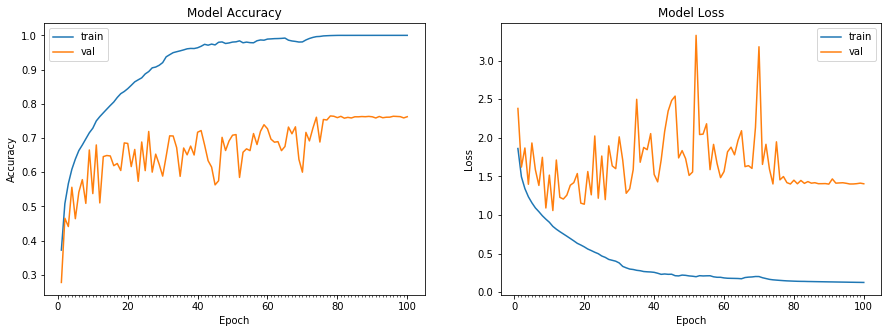

Accuracy on test data is: 11.30


In [9]:

# train the model using some augmentation methods
from keras.preprocessing.image import ImageDataGenerator

# enable image standardization
datagen = ImageDataGenerator(zoom_range=0.0, 
                             samplewise_std_normalization=True,
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 epochs = 100,
                                 validation_data = datagen.flow(test_features, test_labels), 
                                 callbacks=[schedule],
                                 verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Model took 3280.00 seconds to train


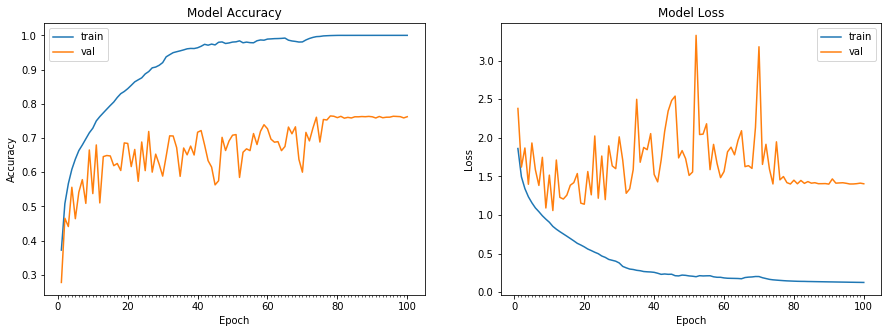

Accuracy on test data is: 11.30


In [10]:
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## The model has overfitt and needs improvisation in terms of regularisation, but the network is functional.